# Femoral and acetabular cartilage segmentation

### Overview
The project focuses on analyzing CT arthrogram images of human diarthrodial joints. The dataset is sourced from Musculoskeletal Research Laboratories (MRL) at the University of Utah. The primary objective is to develop methods for segmenting the femoral and pelvis cartilage from these medical images.

### Data
The dataset is available publicly and consists of three study groups:
1. Normal hip
2. Retroverted acetabula
3. Traditional acetabular dysplasia

<center>

|        | **Age** | **Weight (kg)** | **Height (cm)** | **BMI**  |
|--------|---------|-----------------|-----------------|----------|
| **Mean**   | 25.23   | 74.30           | 176.5           | 23.46    |
| **Median** | 24      | 70.5            | 176.5           | 22.5     |
| **Range**  | 18-36   | 46-130          | 159-197         | 17.1-36.8|

</center>

### Techniques Used


- Region of Interest Finding

Various image classification techniques were employed:

    - Support Vector Machine (SVM)
    - Convolutional Neural Networks (CNN)
    - ResNet

- Segmentation

Two primary methods were used for segmentation:

    - Classical computer vision techniques such as the Hough Transform
    - Segment Anything Model


## Data 

In [ ]:
import os
import cv2
import glob
import pydicom
import numpy as np
import matplotlib.pyplot as plt

filepath = '/home/pappol/Scrivania/uni/medical/FemoralHeadSegmentation/data/normalHip/JOR01'
Pnr = filepath.find('JOR')
Patientnr = filepath[Pnr + len('JOR'):Pnr + len('JOR') + 2]
print('Patient Number:', Patientnr)


In [ ]:
image_files = glob.glob(os.path.join(filepath, '*.dcm'))
image_files.sort()
print('Number of Images =', len(image_files))
print('Image Files =', image_files[0])

In [ ]:
Im = []
Im_Roi = []

for k in range(1, len(image_files)):  # Adjust the range according to your needs
    ds = pydicom.dcmread(image_files[k - 1])
    im = ds.pixel_array  # Load pixel data
    Im.append(im)

    # In this particular dataset, the region of interest (ROI) is defined
    im_roi = im[550:1200, 50:700]

    Im_Roi.append(im_roi)

# Convert the list of NumPy arrays to a NumPy array
Im = np.array(Im)
Im_Roi = np.array(Im_Roi)

print('Shape of the NumPy array =', Im.shape)


In [ ]:
# Specify the slice number (sn) you want to visualize
sn = 357

# Generate the Coronal and Sagittal views
sagittal = np.rot90(np.rot90(Im[:, :, 50+sn]))
sagittal_roi = np.rot90(np.rot90(Im_Roi[:, :, sn-1]))

coronal = np.rot90(np.rot90(Im[:, 550+sn, :]))
coronal_roi = np.rot90(np.rot90(Im_Roi[:, sn - 1, :]))

axial = Im_Roi[sn - 1, :, :]

# Load the axial view image
im = pydicom.dcmread(image_files[sn - 1]).pixel_array


# Create a figure with subplots to display all views
plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.imshow(im, cmap='gray')
plt.title('Whole image, Axial view')

plt.subplot(2, 3, 2)
plt.imshow(coronal, cmap='gray')
plt.title('Whole image, Coronal view')

plt.subplot(2, 3, 3)
plt.imshow(sagittal, cmap='gray')
plt.title('Whole image, Sagittal view')

plt.subplot(2, 3, 4)
plt.imshow(axial, cmap='gray')
plt.title('Axial view')

plt.subplot(2, 3, 5)
plt.imshow(coronal_roi, cmap='gray')
plt.title('Coronal view')

plt.subplot(2, 3, 6)
plt.imshow(sagittal_roi, cmap='gray')
plt.title('Sagittal view')

plt.show()

# Locate femoral head circle

## Classical approach

In [ ]:
def treshold(image):
    _,thresh = cv2.threshold(image,230,255,cv2.THRESH_BINARY)
    thresh = thresh.astype(np.uint8)
    return thresh


In [ ]:
def preprocess(image, verbose=False):
    #apply median filter to reduce noise to coronal view
    preprocessed_image = cv2.GaussianBlur(image,(3,3),0.5)

    thresh = treshold(preprocessed_image)

    # Normalize the image over 255 only positive
    thresh = thresh - min(thresh.flatten())
    thresh = thresh / max(thresh.flatten())
    image = thresh * 255

    #apply opening
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel, iterations=2)
    
    #apply closing
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=2)

    erode = cv2.morphologyEx(closing, cv2.MORPH_ERODE, kernel, iterations=2)
    erode = erode.astype(np.uint8)

    if verbose:
        return image, opening, closing, erode
    else:
        return erode


In [ ]:
def visualize_pre_processing(image):
    scan, morph, closed, erode = preprocess(image, True)

    plt.figure(figsize=(12, 8))
    plt.subplot(2, 3, 1)
    plt.imshow(coronal_roi, cmap='gray')
    plt.title('Original image')

    plt.subplot(2, 3, 2)
    plt.imshow(scan, cmap='gray')
    plt.title('Preprocessed image')

    plt.subplot(2, 3, 3)
    plt.imshow(morph, cmap='gray')
    plt.title('Morphological operations')

    plt.subplot(2, 3, 4)
    plt.imshow(closed, cmap='gray')
    plt.title('Morphological closing')

    plt.subplot(2, 3, 5)
    plt.imshow(erode, cmap='gray')
    plt.title('Morphological erode')

    plt.show()


In [ ]:
visualize_pre_processing(coronal_roi)

In [ ]:
def find_femoral_head(img):
    scan = preprocess(img, False)

    # Detect circles using HoughCircles
    circles = cv2.HoughCircles(
        image=scan, 
        method=cv2.HOUGH_GRADIENT, 
        dp=1, 
        minDist=img.shape[1]/6,
        param1=50,
        param2=30, 
        minRadius=30, 
        maxRadius=3000
    )
    
    scan = cv2.cvtColor(scan, cv2.COLOR_GRAY2RGB)

    if circles is not None:
        circles = np.uint16(np.around(circles))
        
        for circle in circles[0, :]:
            # draw the outer circle
            cv2.circle(scan, (circle[0], circle[1]), circle[2], (255, 10,20), 4)
            # draw the center of the circle
            cv2.circle(scan, (circle[0], circle[1]), 5, (180, 0, 255), 5)
    else:
        print('No circles detected')
    
    return scan, circles

In [ ]:
#test on multiple views
coronal_output , coronal_circles = find_femoral_head(coronal_roi)
sagittal_output , sagittal_circles = find_femoral_head(sagittal_roi)
axial_output , axial_circles = find_femoral_head(axial)

plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1)
plt.imshow(coronal_output, cmap='gray')
plt.title('Coronal view')

plt.subplot(2, 3, 2)
plt.imshow(sagittal_output, cmap='gray')
plt.title('Sagittal view')

plt.subplot(2, 3, 3)
plt.imshow(axial_output, cmap='gray')
plt.title('Axial view')
plt.show()


In [ ]:
#save coronal view
plt.imsave('img/coronal_output.png', coronal_output, cmap='gray')

## Novel approach

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
from numpy import asarray
from ultralytics import SAM

In [2]:
model = SAM()

Model summary: 238 layers, 93735472 parameters, 93735472 gradients



image 1/1 /home/pappol/Scrivania/uni/medical/FemoralHeadSegmentation/img/axial_roi.png: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 3925.6ms
Speed: 12.3ms preprocess, 3925.6ms inference, 0.5ms postprocess per image at shape (1, 3, 1024, 1024)


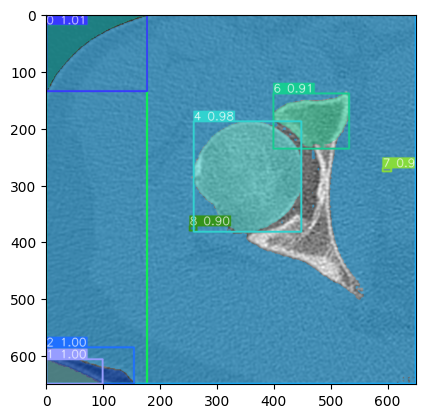

In [3]:
# Display model information (optional)
model.info()
img_path = '/home/pappol/Scrivania/uni/medical/FemoralHeadSegmentation/img/axial_roi.png'

# Run inference
res = model(img_path)  # predict on an image

%matplotlib inline
res_plotted = res[0].plot()
plt.imshow(res_plotted)  # render results
plt.show()

In [4]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

def most_round_segmentation(image, res, threshold_area=1000):
    # Extract segmentations
    segmentations = res[0].masks.xy
    
    # Calculate circularity for each segmentation and find the most round one
    max_circularity = -1
    most_round_segment = None
    for segment in segmentations:
        # Calculate area using contourArea
        area = cv2.contourArea(segment)
        if area < threshold_area:
            continue
        
        # Calculate perimeter using arcLength
        perimeter = cv2.arcLength(segment, True)
        
        # Calculate circularity
        circularity = 4 * np.pi * area / (perimeter**2)
        
        if circularity > max_circularity:
            max_circularity = circularity
            most_round_segment = segment  
    return most_round_segment

In [5]:
image = cv2.imread('/home/pappol/Scrivania/uni/medical/FemoralHeadSegmentation/img/axial_roi.png')
filtered_segmentation_obj = most_round_segmentation(image, res)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_image_with_segmentation(image_path, segmentation):
    """
    Plots an image with a given segmentation overlay and marks the center of the segmentation.
    
    Parameters:
    - image_path: path to the image file.
    - segmentation: list of (x, y) coordinates for the segmentation.
    """
    
    # Load the image
    image = plt.imread(image_path)
    
    # Calculate the centroid of the segmentation
    segmentation_array = np.array(segmentation)
    centroid = np.mean(segmentation_array, axis=0)
    
    # Create a new figure and axes
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Create a polygon patch from the segmentation
    polygon = patches.Polygon(segmentation, fill=False, edgecolor='r', linewidth=2)
    ax.add_patch(polygon)

    # Draw the centroid
    ax.plot(centroid[0], centroid[1], 'bo') # 'bo' means blue color, circle marker
    
    # Annotate the centroid coordinates on the plot
    ax.annotate(f"({centroid[0]:.2f}, {centroid[1]:.2f})", (centroid[0], centroid[1]), color='white', weight='bold')
    
    # Display the image with segmentation overlay and centroid
    plt.show()
    
    # Return the centroid coordinates
    return centroid


image 1/1 /home/pappol/Scrivania/uni/medical/FemoralHeadSegmentation/img/axial_roi.png: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 3704.7ms
Speed: 3.3ms preprocess, 3704.7ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)


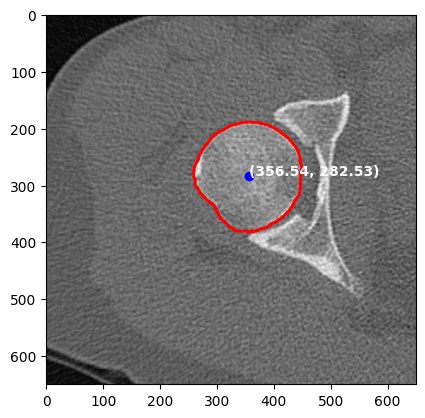

In [7]:
img_path = '/home/pappol/Scrivania/uni/medical/FemoralHeadSegmentation/img/axial_roi.png'
res = model(img_path)  # predict on an image
image = cv2.imread(img_path)

filtered_segmentation_obj = most_round_segmentation(image, res)
axial_center = plot_image_with_segmentation(img_path, filtered_segmentation_obj)

image 1/1 /home/pappol/Scrivania/uni/medical/FemoralHeadSegmentation/img/sagittal_roi.png: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 3716.4ms
Speed: 3.1ms preprocess, 3716.4ms inference, 0.3ms postprocess per image at shape (1, 3, 1024, 1024)


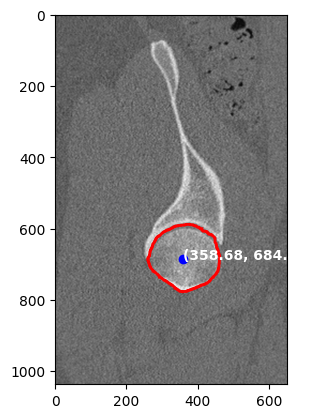

In [8]:
img_path = '/home/pappol/Scrivania/uni/medical/FemoralHeadSegmentation/img/sagittal_roi.png'
image = cv2.imread(img_path)
res = model(img_path)  # predict on an image

filtered_segmentation_obj = most_round_segmentation(image, res)
saggital_center = plot_image_with_segmentation(img_path, filtered_segmentation_obj)

image 1/1 /home/pappol/Scrivania/uni/medical/FemoralHeadSegmentation/img/coronal_roi.png: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 3670.3ms
Speed: 3.0ms preprocess, 3670.3ms inference, 0.3ms postprocess per image at shape (1, 3, 1024, 1024)


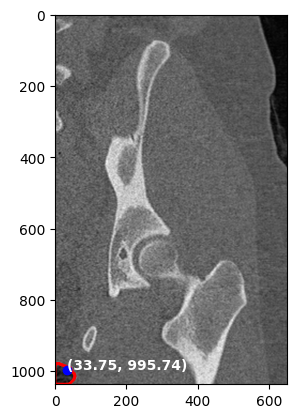

array([     33.755,      995.74], dtype=float32)

In [9]:
img_path = '/home/pappol/Scrivania/uni/medical/FemoralHeadSegmentation/img/coronal_roi.png'

image = cv2.imread(img_path)
res = model(img_path)  # predict on an image

filtered_segmentation_obj = most_round_segmentation(image, res)
plot_image_with_segmentation(img_path, filtered_segmentation_obj)

## Wierd Approach

In [10]:
def find_centroid(img_path, model, verbose=False):
    res = model(img_path)
    image = cv2.imread(img_path)
    
    filtered_segmentation_obj = most_round_segmentation(image, res)

    if verbose:
        centroid = plot_image_with_segmentation(img_path, filtered_segmentation_obj)
    else:
        centroid = np.mean(filtered_segmentation_obj, axis=0)

    return centroid, filtered_segmentation_obj

In [15]:
def index_of_most_round_segment(segmentations, min_area=1000):
    """
    Finds the index of the most round segmentation (contour) within a given area range.
    
    :param segmentations: List of segmentation contours.
    :param min_area: Minimum area threshold for considering a segmentation.
    :param max_area: Maximum area threshold for considering a segmentation.
    :return: Index of the most round segmentation, -1 if none found.
    """
    max_area = -1
    index_of_most_round = -1
    
    for i, segment in enumerate(segmentations):
        area = cv2.contourArea(segment[0])
        if not (min_area <= area):
            continue
        
        if area >max_area:
            max_area = area
            index_of_most_round = i
    
    return index_of_most_round

In [12]:
import os
from tqdm import tqdm
import contextlib


folder_path = '/home/pappol/Scrivania/uni/medical/FemoralHeadSegmentation/data/dataset/normalHip/JOR01/axial'

all_files = os.listdir(folder_path)
print('Number of files =', len(all_files))
# Filter out the list for files with image extensions
# Common image file extensions are .jpg, .jpeg, .png, .gif, .tiff, .bmp, etc.
image_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.tiff', '.bmp'}
image_paths = [file for file in all_files if os.path.splitext(file)[1].lower() in image_extensions]
image_paths = [
    file for file in all_files 
    if os.path.splitext(file)[1].lower() in image_extensions and not file.endswith('SX' + os.path.splitext(file)[1].lower())
]
segmentations = []

for filename in tqdm(image_paths, colour = 'green'):
    if int(filename.split('_')[-2]) % 10 != 0:
                continue
    image_path = os.path.join(folder_path, filename)
    with contextlib.redirect_stdout(None):
        centroid, segmentation = find_centroid(image_path, model)
    segmentations.append((segmentation, image_path))


Number of files = 2074


  0%|          | 0/1037 [00:00<?, ?it/s]
image 1/1 /home/pappol/Scrivania/uni/medical/FemoralHeadSegmentation/data/dataset/normalHip/JOR01/axial/JOR01_880_DX.jpeg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 3698.4ms
Speed: 2.9ms preprocess, 3698.4ms inference, 0.5ms postprocess per image at shape (1, 3, 1024, 1024)
  0%|          | 4/1037 [00:03<16:09,  1.07it/s]
image 1/1 /home/pappol/Scrivania/uni/medical/FemoralHeadSegmentation/data/dataset/normalHip/JOR01/axial/JOR01_700_DX.jpeg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 3706.1ms
Speed: 2.8ms preprocess, 3706.1ms inference, 0.5ms postprocess per image at shape (1, 3, 1024, 1024)
  1%|          | 6/1037 [00:07<22:51,  1.33s/it]
image 1/1 /home/pappol/Scrivania/uni/medical/FemoralHeadSegmentation/data/dataset/normalHip/JOR01/axial/JOR01_1030_DX.jpeg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 3702.2ms
Speed: 2.9ms preprocess, 3702.2ms inference, 0.6ms postprocess per im

In [16]:
#save as a csv file
import csv

with open('segmentations.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['image_path', 'x', 'y'])
    for segmentation, image_path in segmentations:
        centroid = np.mean(segmentation, axis=0)
        writer.writerow([image_path, centroid[0], centroid[1]])

In [17]:
index_of_most_round_segment(segmentations)

17

In [18]:
segmentations[17][1]

'/home/pappol/Scrivania/uni/medical/FemoralHeadSegmentation/data/dataset/normalHip/JOR01/axial/JOR01_260_DX.jpeg'


image 1/1 /home/pappol/Scrivania/uni/medical/FemoralHeadSegmentation/data/dataset/normalHip/JOR01/axial/JOR01_260_DX.jpeg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 3714.4ms
Speed: 10.6ms preprocess, 3714.4ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)


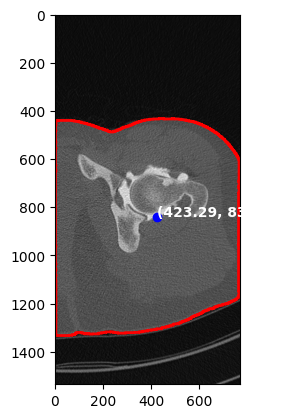

(array([     423.29,      838.41], dtype=float32),
 array([[        434,         431],
        [        434,         432],
        [        433,         433],
        ...,
        [        451,         433],
        [        450,         432],
        [        450,         431]], dtype=float32))

In [19]:
find_centroid('/home/pappol/Scrivania/uni/medical/FemoralHeadSegmentation/data/dataset/normalHip/JOR01/axial/JOR01_260_DX.jpeg', model, verbose=True)
